In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.sparse import coo_matrix
import os
import random
from statsmodels.stats.proportion import binom_test
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def parse_genome(df):
    genome_id = df['#query'][0].split('_')[0]
    keggs = df['KEGG_ko'].replace('-', None).dropna()
    keggs = list(map(lambda x: x.split(','), keggs.values))
    keggs = sum(keggs, [])
    keggs = pd.DataFrame({'KEGG_ko': keggs})
    keggs['genome_id'] = genome_id
    return keggs

def to_sparse_matrix(func_df, genome_id='genome_id', kegg_id='KEGG_ko'):
    # create genome-specific index
    ogus = list(set(func_df[genome_id]))
    ogu_lookup = pd.Series(np.arange(0, len(ogus)), ogus)
    # create KEGG-specific index
    keggs = list(set(func_df[kegg_id]))
    kegg_lookup = pd.Series(np.arange(0, len(keggs)), keggs)
    # rename names as numbers
    ogu_id = func_df[genome_id].apply(lambda x: ogu_lookup.loc[x]).astype(np.int64)
    kegg_id = func_df[kegg_id].apply(lambda x: kegg_lookup.loc[x]).astype(np.int64)
    # assign the presence / absence of a gene
    func_df['count'] = 1
    c = func_df['count'].values
    # format into a matrix
    data = coo_matrix((c, (ogu_id, kegg_id)))
    ko_ogu = pd.DataFrame(data.todense(), index=ogus, columns=keggs)
    return ko_ogu

def btest(pa1, pa2, seed=0, return_proportions=False):
    """ Performs genome wide binomial test between two groups of taxa
    Parameters
    ----------
    df1 : pd.DataFrame
        Rows are taxa, columns are genes
    df2 : pd.DataFrame
        Rows are taxa, columns are genes
    Returns
    -------
    pd.Series : list of genes associated with df1
    pd.Series : list of genes associated with df2
    """
    np.random.seed(seed)
    random.seed(seed)
    #pa1 = df1 > 0
    #pa2 = df2 > 0
    idx = list(set(pa1.columns) | set(pa2.columns))
    idx.sort()
    pa1 = pa1.sum(axis=0).reindex(idx).fillna(0)
    pa2 = pa2.sum(axis=0).reindex(idx).fillna(0)
    n = pa1 + pa2
    obs = list(zip(list(pa1.values), list((pa2.values + 1) / (pa2 + 1).sum()), list(n.values)))
    pvals = pd.Series([binom_test(a, n, b, 'two-sided') for (a, b, n) in obs],
                      index=n.index)
    if return_proportions:
        res = pd.DataFrame({'groupA': pa1, 'groupB': pa2, 'pval': pvals})
        def relabel_f(x):
            if x['groupA'] < x['groupB']:
                return 'groupB'
            else:
                return 'groupA'
        res['side'] = res.apply(relabel_f, axis=1)
        return res

    return pvals

def log_pvalue(lr, alpha=0.1, filter=True):
    """ Converts pvalues to -log(pvalue)
    Also performs Boniferroni correction.
    """
    lr = lr.reset_index()
    # lr.columns = ['KEGG', 'pvalue']
    lr['-log(pvalue)'] = -np.log(lr['pvalue'] + 1e-200)
    res = multipletests(lr['pvalue'], method='fdr_bh', alpha=alpha)
    lr['pvalue_corrected'] = res[1]
    if filter:
        lr = lr.loc[res[0]]
        return lr
    return lr

metadata_new = pd.read_table('table/eggNOG_species_rep_new.txt')
metadata_new = metadata_new.drop_duplicates()

In [2]:
#UC decrease
UC_decreased = pd.read_csv('../../Meta_disease_Jun/Pydeseq2_microbes/UC/bot_microbe.tsv', sep = '\t')
UC_decreased_20 = UC_decreased.head(20)
UC_decreased_20 = list(UC_decreased_20['#OTU ID'].values)
species_UC_decreased_rep = metadata_new[metadata_new['Species'].isin(UC_decreased_20)]
Species_rep_UC_decreased = species_UC_decreased_rep['Species_rep'].drop_duplicates()

In [3]:
#UC increase
UC_increased = pd.read_csv('../../Meta_disease_Jun/Pydeseq2_microbes/UC/top_microbe.tsv', sep = '\t')
UC_increased_20 = UC_increased.head(20)
UC_increased_20 = list(UC_increased_20['#OTU ID'].values)
species_UC_increased_rep = metadata_new[metadata_new['Species'].isin(UC_increased_20)]
Species_rep_UC_increased = species_UC_increased_rep['Species_rep'].drop_duplicates()

In [4]:
df_list_p = []
for i in Species_rep_UC_increased:
    f_name = 'Automate_script/all_2091_species_multi/{}_eggNOG.tsv'.format(i)
    df_parsed = parse_genome(pd.read_table(f_name))
    df_list_p.append(df_parsed)
    
df_cat_p = pd.concat(df_list_p, axis=0)
genome_kegg_counts_p = to_sparse_matrix(df_cat_p)
genome_kegg_counts_p.to_csv('table/UC_increased_20_kegg_new.txt', sep = '\t') 

In [5]:
# eggNOG_dir = 'http://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/species_catalogue/'
# !mkdir Species_rep_UC_increased_20
# for i in Species_rep_UC_increased:
#     os.system("wget '{}/{}/{}/genome/{}_eggNOG.tsv' -O Species_rep_UC_increased_20/{}_eggNOG.tsv".format(eggNOG_dir, i[:-2], i, i, i))

In [6]:
# eggNOG_dir = 'http://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/species_catalogue/'
# !mkdir Species_rep_UC_decreased_20
# for i in Species_rep_UC_decreased:
#     os.system("wget '{}/{}/{}/genome/{}_eggNOG.tsv' -O Species_rep_UC_decreased_20/{}_eggNOG.tsv".format(eggNOG_dir, i[:-2], i, i, i))

In [7]:
df_list_p = []
for i in Species_rep_UC_decreased:
    f_name = 'Automate_script/all_2091_species_multi/{}_eggNOG.tsv'.format(i)
    df_parsed = parse_genome(pd.read_table(f_name))
    df_list_p.append(df_parsed)
    
df_cat_p = pd.concat(df_list_p, axis=0)
genome_kegg_counts_n = to_sparse_matrix(df_cat_p)
genome_kegg_counts_n.to_csv('table/UC_decreased_20_kegg_new.txt', sep = '\t') 

In [8]:
kegg = btest(genome_kegg_counts_n, genome_kegg_counts_p, return_proportions=True)
kegg_p = kegg.loc[kegg['side'] == 'groupB']
kegg_p = kegg_p.loc[kegg['pval'] <= 0.001]
kegg_p.to_csv('table/UC_keggs_differentials_decrease_n_increase_Increased_new.txt', sep = '\t')
new_df = pd.DataFrame({'Index': kegg_p.index,'number': kegg_p['groupB']})
new_df = new_df.reset_index(drop=True)
new_df.to_csv('table/UC_keggs_differentials_decrease_n_increase_Increased_new.txt', sep = '\t')

In [9]:
kegg = btest(genome_kegg_counts_p, genome_kegg_counts_n, return_proportions=True)
kegg_p = kegg.loc[kegg['side'] == 'groupB']
kegg_p = kegg_p.loc[kegg['pval'] <= 0.001]
kegg_p.to_csv('table/UC_keggs_differentials_decrease_n_increase_Decreased.txt', sep = '\t')
new_df = pd.DataFrame({'Index': kegg_p.index,'number': kegg_p['groupB']})
new_df = new_df.reset_index(drop=True)
new_df.to_csv('table/UC_keggs_differentials_decrease_n_increase_Decreased_new.txt', sep = '\t')

In [10]:
kegg_pathway = pd.read_table('table/kegg_UC_increase_20_new.txt')
kegg_pathway = kegg_pathway.fillna(0)
kegg_pathway = kegg_pathway.set_index('Unnamed: 0')
kegg_pathway_de = pd.read_table('table/kegg_UC_decrease_20_new.txt')
kegg_pathway_de = kegg_pathway_de.fillna(0)
kegg_pathway_de = kegg_pathway_de.set_index('Unnamed: 0')
genome_kegg_counts_n_T = genome_kegg_counts_n.T
genome_kegg_counts_n_T_test = genome_kegg_counts_n_T[genome_kegg_counts_n_T.index.isin(kegg_pathway_de.index)]
genome_kegg_counts_n_T_test = genome_kegg_counts_n_T_test.sort_index()
genome_kegg_counts_n_test = genome_kegg_counts_n_T_test.T
kegg_pathway_de = kegg_pathway_de.sort_index()
test_de = genome_kegg_counts_n_test@kegg_pathway_de
test2_de = metadata_new[metadata_new['Species_rep'].isin(test_de.index)]
test2_de = test2_de.set_index('Species_rep')
#merge two test df
test_3_de = pd.merge(test_de, test2_de, left_index=True, right_index=True, how='outer')
test_3_de = test_3_de.set_index('Species')
test_3_de = test_3_de.iloc[:, :-5]
genome_kegg_counts_p_T = genome_kegg_counts_p.T
genome_kegg_counts_p_T_test = genome_kegg_counts_p_T[genome_kegg_counts_p_T.index.isin(kegg_pathway.index)]
genome_kegg_counts_p_T_test = genome_kegg_counts_p_T_test.sort_index()
genome_kegg_counts_p_test = genome_kegg_counts_p_T_test.T
kegg_pathway = kegg_pathway.sort_index()
test = genome_kegg_counts_p_test@kegg_pathway
test2 = metadata_new[metadata_new['Species_rep'].isin(test.index)]
test2 = test2.set_index('Species_rep')

#merge two test df
test_3 = pd.merge(test, test2, left_index=True, right_index=True, how='outer')
test_3 = test_3.set_index('Species')
test_3 = test_3.iloc[:, :-5]

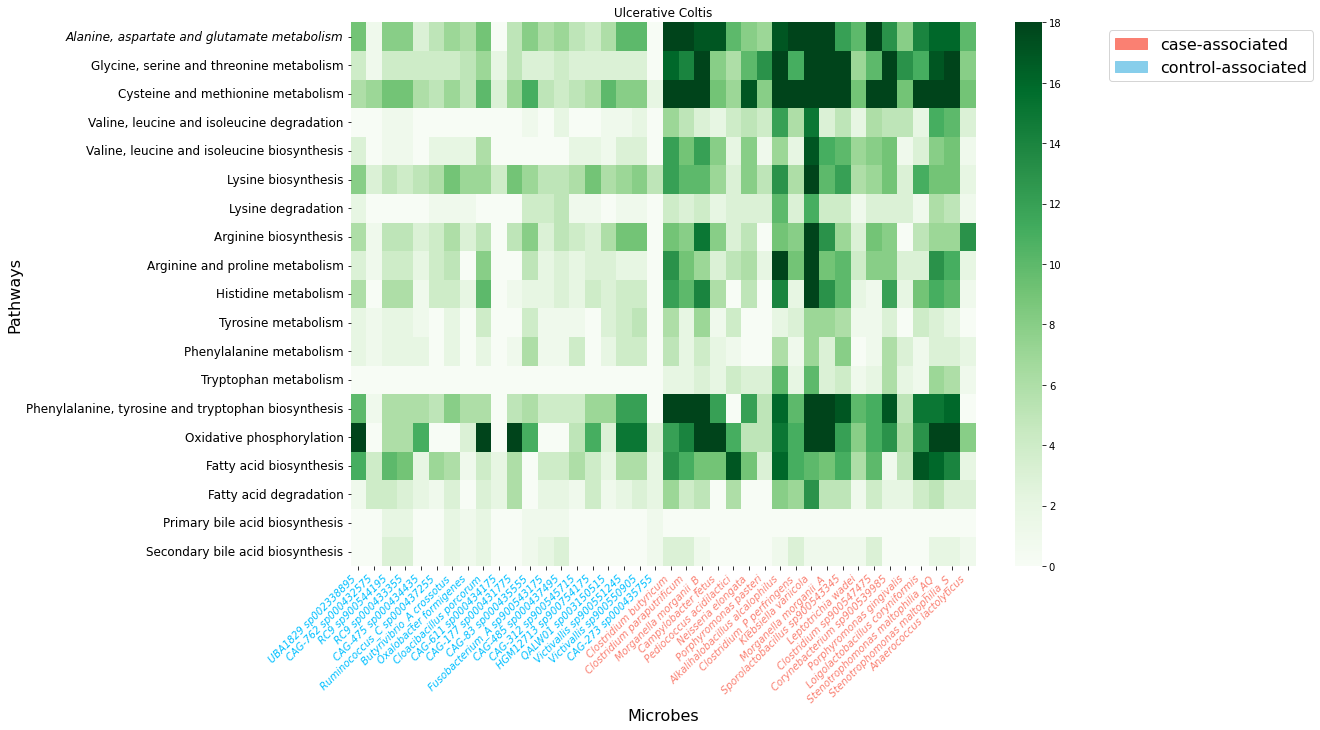

In [11]:
df1 = test_3_de
df2 = test_3
combined_df = pd.concat([df1, df2], axis=0)
sorted_combined_df = combined_df.T

plt.figure(figsize=(14, 10))
ax = sns.heatmap(sorted_combined_df, cmap='Greens', vmin=0, vmax=18)
#plt.ylabel('Amino Acid Metabolism, Energy Metabolism, and Lipid Metabolism Pathways in UC',fontsize=16)
plt.ylabel('Pathways',fontsize=16)
plt.xlabel('Microbes',fontsize=16)
plt.xticks(rotation=45, ha='right',fontsize=12)
# Get the current font properties
font_properties = plt.gca().get_yticklabels()[0].get_font_properties()

# Set the font style to italic
font_properties.set_style('italic')

#Update the font properties for x-axis labels
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), fontdict={'fontproperties': font_properties})
plt.yticks(fontsize=12)
legend_patches = []
for i, tick_label in enumerate(ax.axes.get_xticklabels()):
    if tick_label.get_text() in df1.index:
        tick_label.set_color("deepskyblue")
    elif tick_label.get_text() in df2.index:
        tick_label.set_color("salmon")
legend_patches.append(mpatches.Patch(color="salmon", label="case-associated"))
legend_patches.append(mpatches.Patch(color="skyblue", label="control-associated"))
plt.legend(handles=legend_patches, bbox_to_anchor=(1.2, 1), loc='upper left',fontsize=16)
plt.title('Ulcerative Coltis')
plt.savefig('Figure4_UC_increased_top_20_vs_decreased_20.pdf', bbox_inches="tight")

In [37]:
#CD
CD_decreased = pd.read_csv('../../Meta_disease_Jun/Pydeseq2_microbes/CD/bot_microbe.tsv', sep = '\t')
CD_decreased_20 = CD_decreased.head(20)
CD_decreased_20 = list(CD_decreased_20['#OTU ID'].values)
species_CD_decreased_rep = metadata_new[metadata_new['Species'].isin(CD_decreased_20)]
Species_rep_CD_decreased = species_CD_decreased_rep['Species_rep'].drop_duplicates()

#CD increase
CD_increased = pd.read_csv('../../Meta_disease_Jun/Pydeseq2_microbes/CD/top_microbe.tsv', sep = '\t')
CD_increased_20 = CD_increased.head(20)
CD_increased_20 = list(CD_increased_20['#OTU ID'].values)
species_CD_increased_rep = metadata_new[metadata_new['Species'].isin(CD_increased_20)]
Species_rep_CD_increased = species_CD_increased_rep['Species_rep'].drop_duplicates()

df_list_p = []
for i in Species_rep_CD_increased:
    f_name = 'Automate_script/all_2091_species_multi/{}_eggNOG.tsv'.format(i)
    df_parsed = parse_genome(pd.read_table(f_name))
    df_list_p.append(df_parsed)
    
df_cat_p = pd.concat(df_list_p, axis=0)
genome_kegg_counts_p = to_sparse_matrix(df_cat_p)
genome_kegg_counts_p.to_csv('table/CD_increased_20_kegg_new.txt', sep = '\t') 


df_list_p = []
for i in Species_rep_CD_decreased:
    f_name = 'Automate_script/all_2091_species_multi/{}_eggNOG.tsv'.format(i)
    df_parsed = parse_genome(pd.read_table(f_name))
    df_list_p.append(df_parsed)
    
df_cat_p = pd.concat(df_list_p, axis=0)
genome_kegg_counts_n = to_sparse_matrix(df_cat_p)
genome_kegg_counts_n.to_csv('table/CD_decreased_20_kegg_new.txt', sep = '\t') 


kegg = btest(genome_kegg_counts_n, genome_kegg_counts_p, return_proportions=True)
kegg_p = kegg.loc[kegg['side'] == 'groupB']
kegg_p = kegg_p.loc[kegg['pval'] <= 0.001]
kegg_p.to_csv('table/CD_keggs_differentials_decrease_n_increase_Increased_new.txt', sep = '\t')
new_df = pd.DataFrame({'Index': kegg_p.index,'number': kegg_p['groupB']})
new_df = new_df.reset_index(drop=True)
new_df.to_csv('table/CD_keggs_differentials_decrease_n_increase_Increased_new.txt', sep = '\t')


kegg = btest(genome_kegg_counts_p, genome_kegg_counts_n, return_proportions=True)
kegg_p = kegg.loc[kegg['side'] == 'groupB']
kegg_p = kegg_p.loc[kegg['pval'] <= 0.001]
kegg_p.to_csv('table/CD_keggs_differentials_decrease_n_increase_Decreased.txt', sep = '\t')
new_df = pd.DataFrame({'Index': kegg_p.index,'number': kegg_p['groupB']})
new_df = new_df.reset_index(drop=True)
new_df.to_csv('table/CD_keggs_differentials_decrease_n_increase_Decreased_new.txt', sep = '\t')

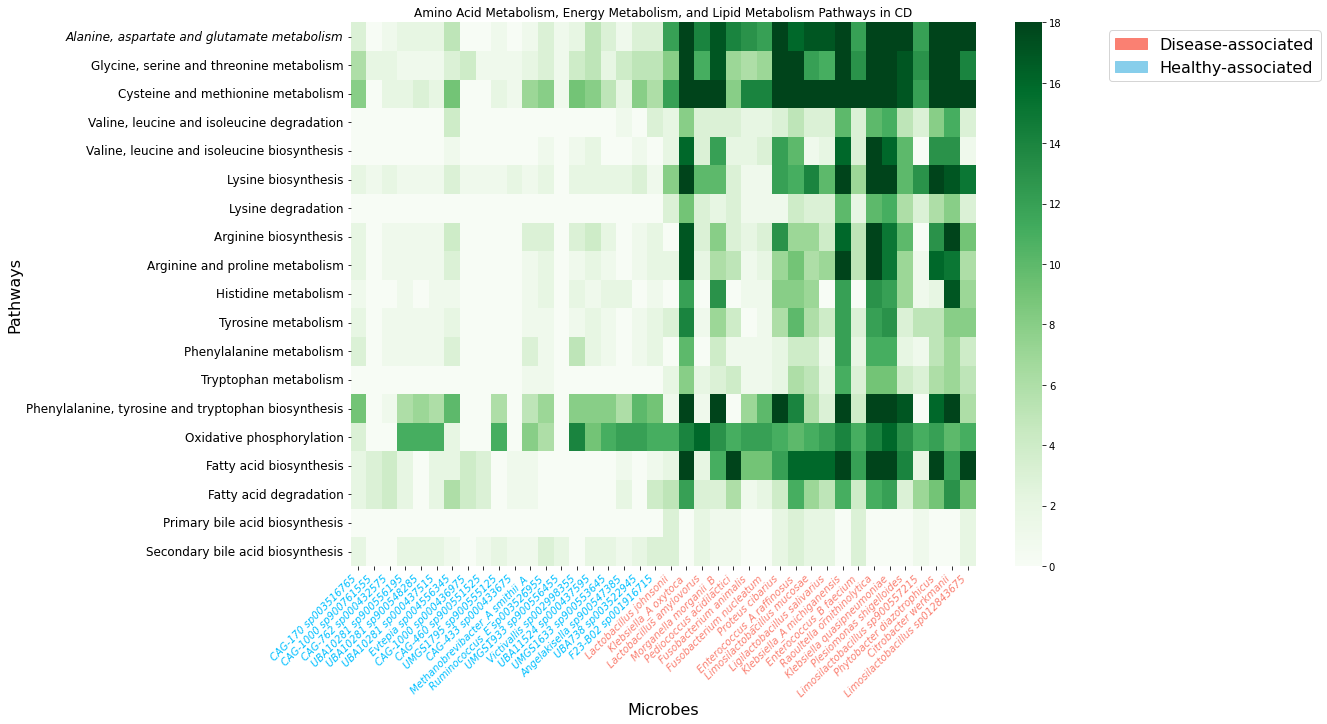

In [40]:
kegg_pathway = pd.read_table('table/kegg_CD_increase_20_new.txt')
kegg_pathway = kegg_pathway.fillna(0)
kegg_pathway = kegg_pathway.set_index('Unnamed: 0')
kegg_pathway_de = pd.read_table('table/kegg_CD_decrease_20_new.txt')
kegg_pathway_de = kegg_pathway_de.fillna(0)
kegg_pathway_de = kegg_pathway_de.set_index('Unnamed: 0')
genome_kegg_counts_n_T = genome_kegg_counts_n.T
genome_kegg_counts_n_T_test = genome_kegg_counts_n_T[genome_kegg_counts_n_T.index.isin(kegg_pathway_de.index)]
genome_kegg_counts_n_T_test = genome_kegg_counts_n_T_test.sort_index()
genome_kegg_counts_n_test = genome_kegg_counts_n_T_test.T
kegg_pathway_de = kegg_pathway_de.sort_index()
test_de = genome_kegg_counts_n_test@kegg_pathway_de
test2_de = metadata_new[metadata_new['Species_rep'].isin(test_de.index)]
test2_de = test2_de.set_index('Species_rep')
#merge two test df
test_3_de = pd.merge(test_de, test2_de, left_index=True, right_index=True, how='outer')
test_3_de = test_3_de.set_index('Species')
test_3_de = test_3_de.iloc[:, :-5]
genome_kegg_counts_p_T = genome_kegg_counts_p.T
genome_kegg_counts_p_T_test = genome_kegg_counts_p_T[genome_kegg_counts_p_T.index.isin(kegg_pathway.index)]
genome_kegg_counts_p_T_test = genome_kegg_counts_p_T_test.sort_index()
genome_kegg_counts_p_test = genome_kegg_counts_p_T_test.T
kegg_pathway = kegg_pathway.sort_index()
test = genome_kegg_counts_p_test@kegg_pathway
test2 = metadata_new[metadata_new['Species_rep'].isin(test.index)]
test2 = test2.set_index('Species_rep')

#merge two test df
test_3 = pd.merge(test, test2, left_index=True, right_index=True, how='outer')
test_3 = test_3.set_index('Species')
test_3 = test_3.iloc[:, :-5]

df1 = test_3_de
df2 = test_3
combined_df = pd.concat([df1, df2], axis=0)
sorted_combined_df = combined_df.T

plt.figure(figsize=(14, 10))
ax = sns.heatmap(sorted_combined_df, cmap='Greens', vmin=0, vmax=18)
plt.xlabel('Microbes',fontsize=16)
#plt.xlabel('Amino Acid Metabolism in CD',fontsize=16)
plt.ylabel('Pathways',fontsize=16)
plt.xticks(rotation=45, ha='right',fontsize=12)
# Get the current font properties
font_properties = plt.gca().get_yticklabels()[0].get_font_properties()

# Set the font style to italic
font_properties.set_style('italic')

# Update the font properties for x-axis labels
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), fontdict={'fontproperties': font_properties})
plt.yticks(fontsize=12)
legend_patches = []
for i, tick_label in enumerate(ax.axes.get_xticklabels()):
    if tick_label.get_text() in df1.index:
        tick_label.set_color("deepskyblue")
    elif tick_label.get_text() in df2.index:
        tick_label.set_color("salmon")
legend_patches.append(mpatches.Patch(color="salmon", label="case-associated"))
legend_patches.append(mpatches.Patch(color="skyblue", label="control-associated"))
plt.legend(handles=legend_patches, bbox_to_anchor=(1.2, 1), loc='upper left',fontsize=16)
plt.title('Crohns Disease')
plt.savefig('Figure4_CD_increased_top_20_vs_decreased_20.pdf', bbox_inches="tight")

In [41]:
#AD
AD_decreased = pd.read_csv('../../Meta_disease_Jun/Pydeseq2_microbes/AD/bot_microbe.tsv', sep = '\t')
AD_decreased_20 = AD_decreased.head(20)
AD_decreased_20 = list(AD_decreased_20['#OTU ID'].values)
species_AD_decreased_rep = metadata_new[metadata_new['Species'].isin(AD_decreased_20)]
Species_rep_AD_decreased = species_AD_decreased_rep['Species_rep'].drop_duplicates()

#AD increase
#AD_increased_20 = pd.read_csv('deseq2_microbes/AD_top_20_shapley_lfc_CI_no_0.txt', sep = '\t')
AD_increased = pd.read_csv('../../Meta_disease_Jun/Pydeseq2_microbes/AD/top_microbe.tsv', sep = '\t')
AD_increased_20 = AD_increased.head(20)
AD_increased_20 = list(AD_increased_20['#OTU ID'].values)
species_AD_increased_rep = metadata_new[metadata_new['Species'].isin(AD_increased_20)]
Species_rep_AD_increased = species_AD_increased_rep['Species_rep'].drop_duplicates()

df_list_p = []
for i in Species_rep_AD_increased:
    f_name = 'Automate_script/all_2091_species_multi/{}_eggNOG.tsv'.format(i)
    df_parsed = parse_genome(pd.read_table(f_name))
    df_list_p.append(df_parsed)
    
df_cat_p = pd.concat(df_list_p, axis=0)
genome_kegg_counts_p = to_sparse_matrix(df_cat_p)
genome_kegg_counts_p.to_csv('table/AD_increased_20_kegg_new.txt', sep = '\t') 


df_list_p = []
for i in Species_rep_AD_decreased:
    f_name = 'Automate_script/all_2091_species_multi/{}_eggNOG.tsv'.format(i)
    df_parsed = parse_genome(pd.read_table(f_name))
    df_list_p.append(df_parsed)
    
df_cat_p = pd.concat(df_list_p, axis=0)
genome_kegg_counts_n = to_sparse_matrix(df_cat_p)
genome_kegg_counts_n.to_csv('table/AD_decreased_20_kegg_new.txt', sep = '\t') 


kegg = btest(genome_kegg_counts_n, genome_kegg_counts_p, return_proportions=True)
kegg_p = kegg.loc[kegg['side'] == 'groupB']
kegg_p = kegg_p.loc[kegg['pval'] <= 0.001]
kegg_p.to_csv('table/AD_keggs_differentials_decrease_n_increase_Increased_new.txt', sep = '\t')
new_df = pd.DataFrame({'Index': kegg_p.index,'number': kegg_p['groupB']})
new_df = new_df.reset_index(drop=True)
new_df.to_csv('table/AD_keggs_differentials_decrease_n_increase_Increased_new.txt', sep = '\t')


kegg = btest(genome_kegg_counts_p, genome_kegg_counts_n, return_proportions=True)
kegg_p = kegg.loc[kegg['side'] == 'groupB']
kegg_p = kegg_p.loc[kegg['pval'] <= 0.001]
kegg_p.to_csv('table/AD_keggs_differentials_decrease_n_increase_Decreased.txt', sep = '\t')
new_df = pd.DataFrame({'Index': kegg_p.index,'number': kegg_p['groupB']})
new_df = new_df.reset_index(drop=True)
new_df.to_csv('table/AD_keggs_differentials_decrease_n_increase_Decreased_new.txt', sep = '\t')

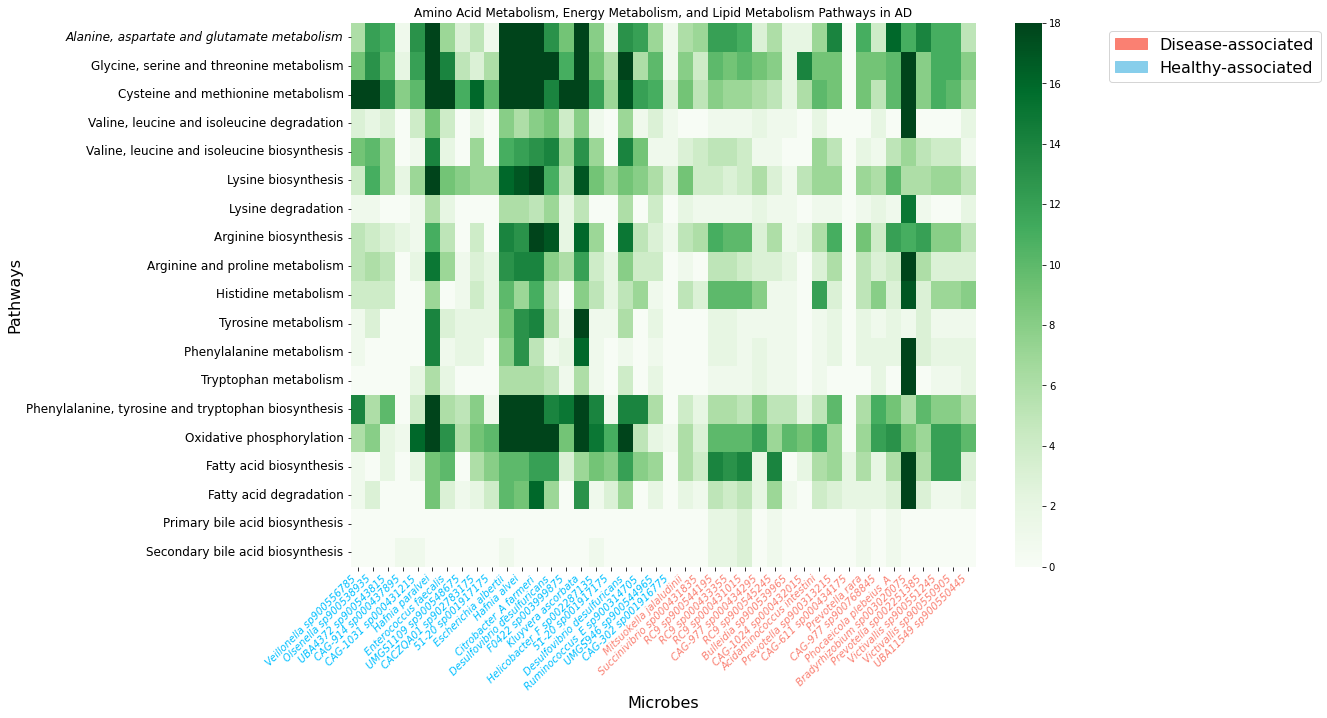

In [42]:
kegg_pathway = pd.read_table('table/kegg_AD_increase_20_new.txt')
kegg_pathway = kegg_pathway.fillna(0)
kegg_pathway = kegg_pathway.set_index('Unnamed: 0')
kegg_pathway_de = pd.read_table('table/kegg_AD_decrease_20_new.txt')
kegg_pathway_de = kegg_pathway_de.fillna(0)
kegg_pathway_de = kegg_pathway_de.set_index('Unnamed: 0')
genome_kegg_counts_n_T = genome_kegg_counts_n.T
genome_kegg_counts_n_T_test = genome_kegg_counts_n_T[genome_kegg_counts_n_T.index.isin(kegg_pathway_de.index)]
genome_kegg_counts_n_T_test = genome_kegg_counts_n_T_test.sort_index()
genome_kegg_counts_n_test = genome_kegg_counts_n_T_test.T
kegg_pathway_de = kegg_pathway_de.sort_index()
test_de = genome_kegg_counts_n_test@kegg_pathway_de
test2_de = metadata_new[metadata_new['Species_rep'].isin(test_de.index)]
test2_de = test2_de.set_index('Species_rep')
#merge two test df
test_3_de = pd.merge(test_de, test2_de, left_index=True, right_index=True, how='outer')
test_3_de = test_3_de.set_index('Species')
test_3_de = test_3_de.iloc[:, :-5]
genome_kegg_counts_p_T = genome_kegg_counts_p.T
genome_kegg_counts_p_T_test = genome_kegg_counts_p_T[genome_kegg_counts_p_T.index.isin(kegg_pathway.index)]
genome_kegg_counts_p_T_test = genome_kegg_counts_p_T_test.sort_index()
genome_kegg_counts_p_test = genome_kegg_counts_p_T_test.T
kegg_pathway = kegg_pathway.sort_index()
test = genome_kegg_counts_p_test@kegg_pathway
test2 = metadata_new[metadata_new['Species_rep'].isin(test.index)]
test2 = test2.set_index('Species_rep')

#merge two test df
test_3 = pd.merge(test, test2, left_index=True, right_index=True, how='outer')
test_3 = test_3.set_index('Species')
test_3 = test_3.iloc[:, :-5]

df1 = test_3_de
df2 = test_3
combined_df = pd.concat([df1, df2], axis=0)
sorted_combined_df = combined_df.T

plt.figure(figsize=(14, 10))
ax = sns.heatmap(sorted_combined_df, cmap='Greens', vmin=0, vmax=18)
plt.xlabel('Microbes',fontsize=16)
#plt.xlabel('Amino Acid Metabolism in AD',fontsize=16)
plt.ylabel('Pathways',fontsize=16)
plt.xticks(rotation=45, ha='right',fontsize=12)
# Get the current font properties
font_properties = plt.gca().get_yticklabels()[0].get_font_properties()

# Set the font style to italic
font_properties.set_style('italic')

# Update the font properties for x-axis labels
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), fontdict={'fontproperties': font_properties})
plt.yticks(fontsize=12)
legend_patches = []
for i, tick_label in enumerate(ax.axes.get_xticklabels()):
    if tick_label.get_text() in df1.index:
        tick_label.set_color("deepskyblue")
    elif tick_label.get_text() in df2.index:
        tick_label.set_color("salmon")
legend_patches.append(mpatches.Patch(color="salmon", label="case-associated"))
legend_patches.append(mpatches.Patch(color="skyblue", label="control-associated"))
plt.legend(handles=legend_patches, bbox_to_anchor=(1.2, 1), loc='upper left',fontsize=16)
plt.title('Alzheimers Disease')
#plt.show()
plt.savefig('Figure4_AD_increased_top_20_vs_decreased_20.pdf', bbox_inches="tight")